In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /Users/gokcen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2024-05-29 15:41:47.374224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
df= pd.read_csv('labeled_data.csv')
df.drop('Unnamed: 0',axis=1, inplace=True)
# İlk birkaç satırı görüntüleme
print("İlk birkaç satır:\n", df.head())

# Sütun adları
print("Sütun adları:\n", df.columns)

# Veri setinin genel bilgileri
print("Veri seti bilgileri:\n", df.info())

# Rastgele örnek kayıtlar
print("Rastgele örnek kayıtlar:\n", df.sample(5))

# Sınıf dağılımı
print("Sınıf dağılımı:\n", df['class'].value_counts())

İlk birkaç satır:
    count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
Sütun adları:
 Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
-

In [6]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

In [8]:
def plot_learning_curve(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Accuracy (training data)')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    plt.title('Model Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [10]:
def plot_classification_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
def show_processed_data(df, num_samples=5):
    print(df[['clean_text', 'tokens']].sample(num_samples))

In [14]:
df['clean_text'] = df['tweet'].apply(clean_text)
df['tokens'] = df['clean_text'].apply(word_tokenize)

In [16]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['clean_text'])
X_tfidf_dense = X_tfidf.toarray()

In [18]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_tfidf_dense, df['class'])

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_smote.shape[1]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])



In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [24]:

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
720/720 [==============================] - 38s 52ms/step - loss: 0.3111 - accuracy: 0.8882 - val_loss: 0.0869 - val_accuracy: 0.9732
Epoch 2/20
720/720 [==============================] - 30s 41ms/step - loss: 0.0564 - accuracy: 0.9847 - val_loss: 0.0615 - val_accuracy: 0.9807
Epoch 3/20
720/720 [==============================] - 30s 42ms/step - loss: 0.0235 - accuracy: 0.9939 - val_loss: 0.0646 - val_accuracy: 0.9823
Epoch 4/20
720/720 [==============================] - 32s 45ms/step - loss: 0.0130 - accuracy: 0.9967 - val_loss: 0.0783 - val_accuracy: 0.9797
Epoch 5/20
720/720 [==============================] - 33s 46ms/step - loss: 0.0086 - accuracy: 0.9979 - val_loss: 0.0815 - val_accuracy: 0.9821
Epoch 6/20
720/720 [==============================] - 31s 43ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0779 - val_accuracy: 0.9828
Epoch 7/20
720/720 [==============================] - 32s 44ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.1144 - val_accuracy:

In [26]:
model.save('Tf_model.h5')

360/360 [==============================] - 3s 5ms/step
TensorFlow Model Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      3849
     Class 1       0.99      0.96      0.98      3794
     Class 2       0.98      0.99      0.99      3871

    accuracy                           0.98     11514
   macro avg       0.98      0.98      0.98     11514
weighted avg       0.98      0.98      0.98     11514

Accuracy: 0.9845405593190898


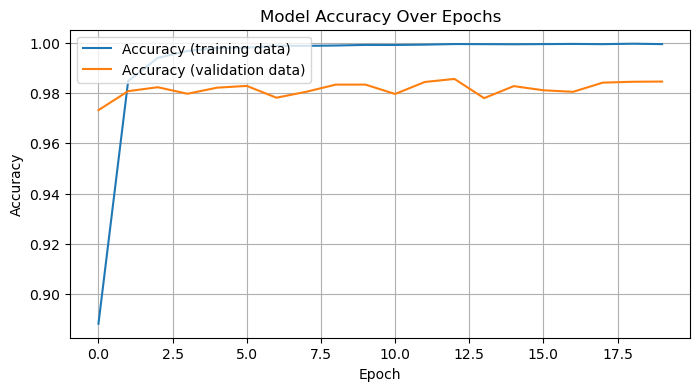

In [28]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print("TensorFlow Model Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))
print("Accuracy:", accuracy_score(y_test, y_pred))
plot_learning_curve(history)

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
# Random Forest Modeli
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))



Random Forest Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99      3849
     Class 1       0.97      0.95      0.96      3794
     Class 2       0.97      0.98      0.97      3871

    accuracy                           0.97     11514
   macro avg       0.97      0.97      0.97     11514
weighted avg       0.97      0.97      0.97     11514



In [38]:
from sklearn.naive_bayes import MultinomialNB

In [40]:
# Naive Bayes Modeli
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.98      0.92      3849
     Class 1       0.95      0.83      0.88      3794
     Class 2       0.95      0.97      0.96      3871

    accuracy                           0.92     11514
   macro avg       0.93      0.92      0.92     11514
weighted avg       0.93      0.92      0.92     11514



In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [44]:
# TensorFlow model performans metrikleri
tf_y_pred = np.argmax(model.predict(X_test), axis=1)
tf_accuracy = accuracy_score(y_test, tf_y_pred)
tf_precision, tf_recall, tf_f1, _ = precision_recall_fscore_support(y_test, tf_y_pred, average='weighted')



360/360 [==============================] - 2s 6ms/step


In [46]:
# Random Forest model performans metrikleri
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, rf_y_pred, average='weighted')


In [48]:
# Random Forest model performans metrikleri
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, rf_y_pred, average='weighted')


In [52]:
# Naive Bayes model performans metrikleri
nb_y_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(y_test, nb_y_pred, average='weighted')


In [54]:
metrics = pd.DataFrame({
    'Model': ['TensorFlow', 'Random Forest', 'Naive Bayes'],
    'Accuracy': [tf_accuracy, rf_accuracy, nb_accuracy],
    'Precision': [tf_precision, rf_precision, nb_precision],
    'Recall': [tf_recall, rf_recall, nb_recall],
    'F1-Score': [tf_f1, rf_f1, nb_f1]
})

In [56]:
print(metrics)

           Model  Accuracy  Precision    Recall  F1-Score
0     TensorFlow  0.984541   0.984694  0.984541  0.984469
1  Random Forest  0.974379   0.974364  0.974379  0.974319
2    Naive Bayes  0.923484   0.926255  0.923484  0.922537


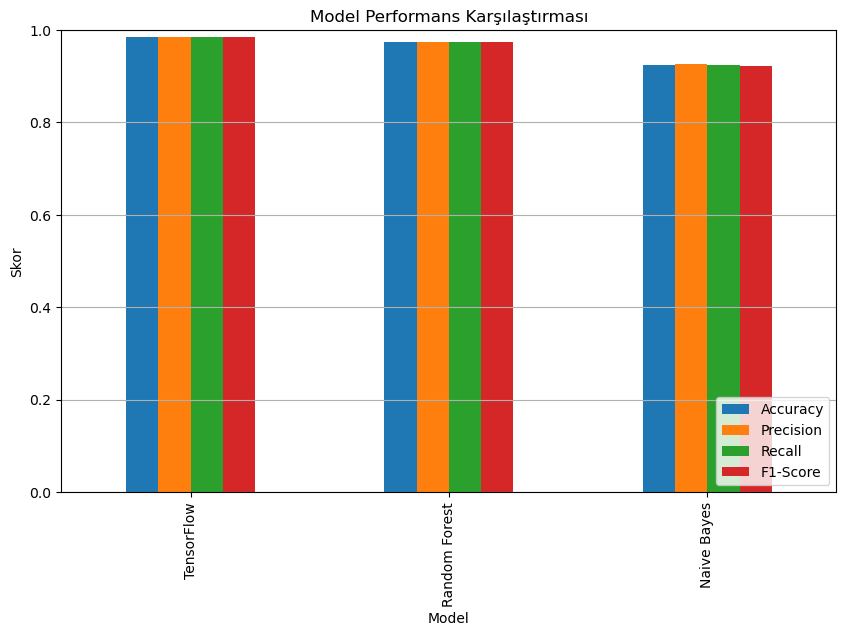

In [58]:
metrics.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Skor')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

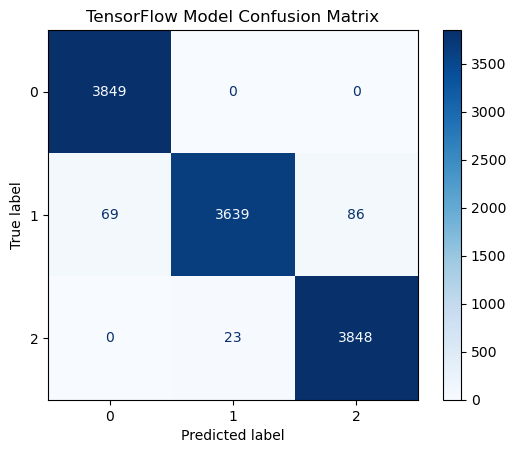

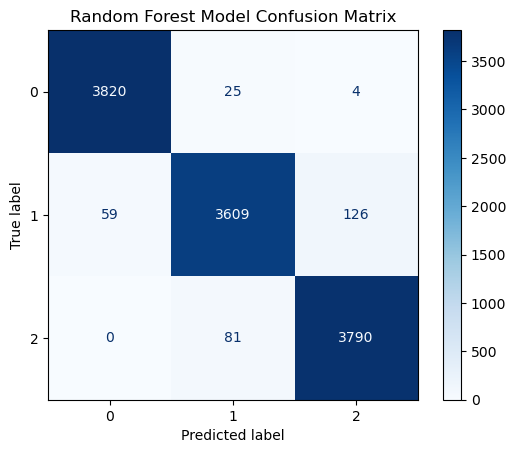

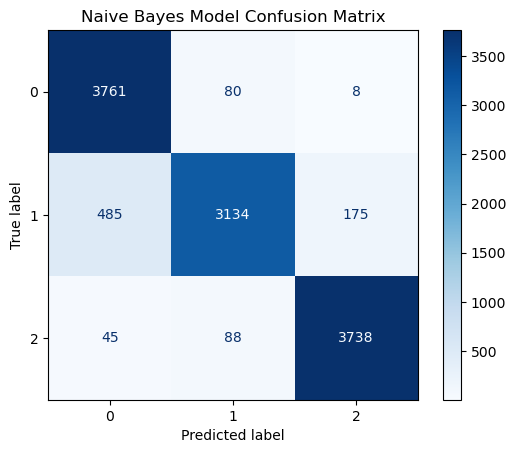

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# TensorFlow model
plot_confusion_matrix(y_test, tf_y_pred, 'TensorFlow Model Confusion Matrix')

# Random Forest model
plot_confusion_matrix(y_test, rf_y_pred, 'Random Forest Model Confusion Matrix')

# Naive Bayes model
plot_confusion_matrix(y_test, nb_y_pred, 'Naive Bayes Model Confusion Matrix')
